<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/read_image_root_py3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np    

%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os
import time


from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
myhost = os.uname()[1]
if myhost == 'macmazzitelli.lnf.infn.it':
    mybasepath = '/Users/mazzitel/Dropbox/GR2/soft/data/'
    posix=False
else:
    mybasepath = '/workarea/cloud-storage/mazzitel/'
    posix=True
print("Host:", myhost)
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '3':
    mybasepath = './'
    posix=False
    print('Running on CoLab')
    !wget https://raw.githubusercontent.com/gmazzitelli/cygno_cloud/main/cygnus_lib.py
    !wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
    !madir out
    !mkdir ped
    # credits https://gist.github.com/MohamedElashri/
    !wget https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/Analysis/root.tar.gz
    !gunzip root.tar.gz
    !tar -xf  root.tar
    !apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion
    !install root_numpy
    
    import sys
    sys.path.append("/content/root_build/")
    sys.path.append("/content/root_build/bin/")
    sys.path.append("/content/root_build/include/")
    sys.path.append("/content/root_build/lib/")
    import ctypes
    libfile = !ls /content/root_build/lib/*.so*
    for i, lib in enumerate(libfile):
        if not (lib=='/content/root_build/lib/libtbbmalloc_proxy.so' or lib=='/content/root_build/lib/libtbbmalloc.so' or lib=='/content/root_build/lib/libtbb.so'): 
            ctypes.cdll.LoadLibrary(lib)
    !pip install root-numpy

import cygnus_lib as cy
import mylib as my
import ROOT
import root_numpy as rtnp

Host: 9e9dbc7872f7
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0] <google.colab._shell.Shell object at 0x7f4c0b1f9a10>
Running on CoLab
--2021-05-04 12:52:41--  https://raw.githubusercontent.com/gmazzitelli/cygno_cloud/main/cygnus_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42895 (42K) [text/plain]
Saving to: ‘cygnus_lib.py’

cygnus_lib.py       100%[===================>]  41.89K  --.-KB/s    in 0.006s  

2021-05-04 12:52:42 (7.23 MB/s) - ‘cygnus_lib.py’ saved [42895/42895]

--2021-05-04 12:52:42--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserc

In [2]:
def root_TH2_name(root_file):
    pic = []
    wfm = []
    for i,e in enumerate(root_file.GetListOfKeys()):
        che = e.GetName()
        if ('pic_run' in str(che)):
            pic.append(che)
        elif ('wfm_run' in str(che)):
            wfm.append(che)
    return pic, wfm
def reporthook(blocknum, blocksize, totalsize):
    import sys
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        sys.stderr.write(s)
        if readsofar >= totalsize: # near the end
            sys.stderr.write("\n")
    else: # total size is unknown
        sys.stderr.write("read %d\n" % (readsofar,))
def s3_root_file(sel, run, posix=False):
    import os
    import urllib.request
    from platform import python_version
    BASE_URL  = "https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/"
    file_root = ('Data/'+sel+'/histograms_Run%05d.root' % run)
    path = url =  BASE_URL+file_root
    if posix:
        fname=('histograms_Run%05d.root' % run)
        urllib.request.urlretrieve(url, fname, reporthook)
        path = './'+fname

    return path
tag = 'LAB'
run=3965
posix=True

Open file: https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/Data/LAB/histograms_Run04020.root


100.0% 414883840 / 414882651


Find Keys: 100
# of Images (TH2) Files: 100
# of Waveform (TH2) Files: 0 
Camera X, Y pixel: 2304 2304 


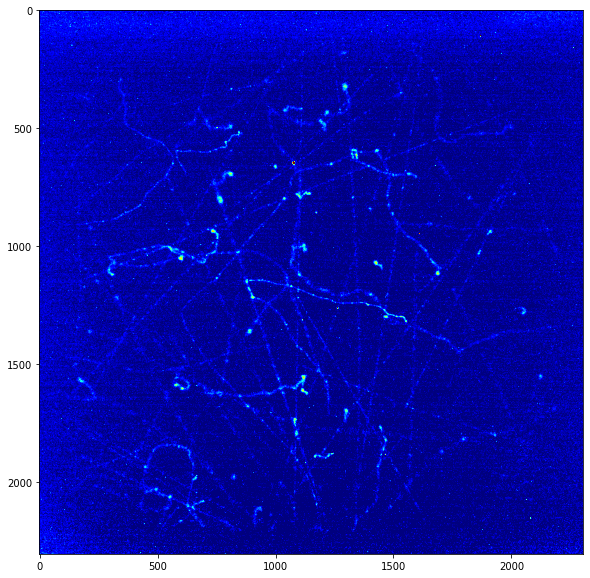

In [3]:
run = 4020
tag = "LAB"
print ('Open file: '+s3_root_file(tag, run))
f = ROOT.TFile.Open(s3_root_file(tag, run, posix=True))
print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: {:d}".format(max_image))
print ("# of Waveform (TH2) Files: {:d} ".format(max_wfm))
image = rtnp.hist2array(f.Get(pic[0])).T
x_resolution = image.shape[1]
y_resolution = image.shape[0]
print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))
fig = plt.figure(figsize=(10,10))
plt.imshow(image,  cmap="jet", vmin=98,vmax=150)
plt.show()